# Cell simulation

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, '/Users/josephmin/Documents/GitHub/spateo-release')
import spateo as st
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%config InlineBackend.figure_format='retina'

st.config.n_threads = 4

OMP: Info #270: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


## Simulate cells

In [2]:
adata = st.pp.segmentation.simulation.simulate_cells(
    (1000, 1000),  # FOV shape
    100,           # Number of cells to simulate
    axis1_range=(7, 15), axis2_range=(5, 14),
    shift=3,
    foreground_params=(0.512, 1.96, 11.4),
    background_params=(0.921, 1.08, 1.74),
    seed=0
)

|-----> <insert> __type to uns in AnnData Object.
|-----> <insert> pp to uns in AnnData Object.
|-----> <insert> spatial to uns in AnnData Object.


|-----> <select> X layer in AnnData Object
|-----> <select> labels layer in AnnData Object


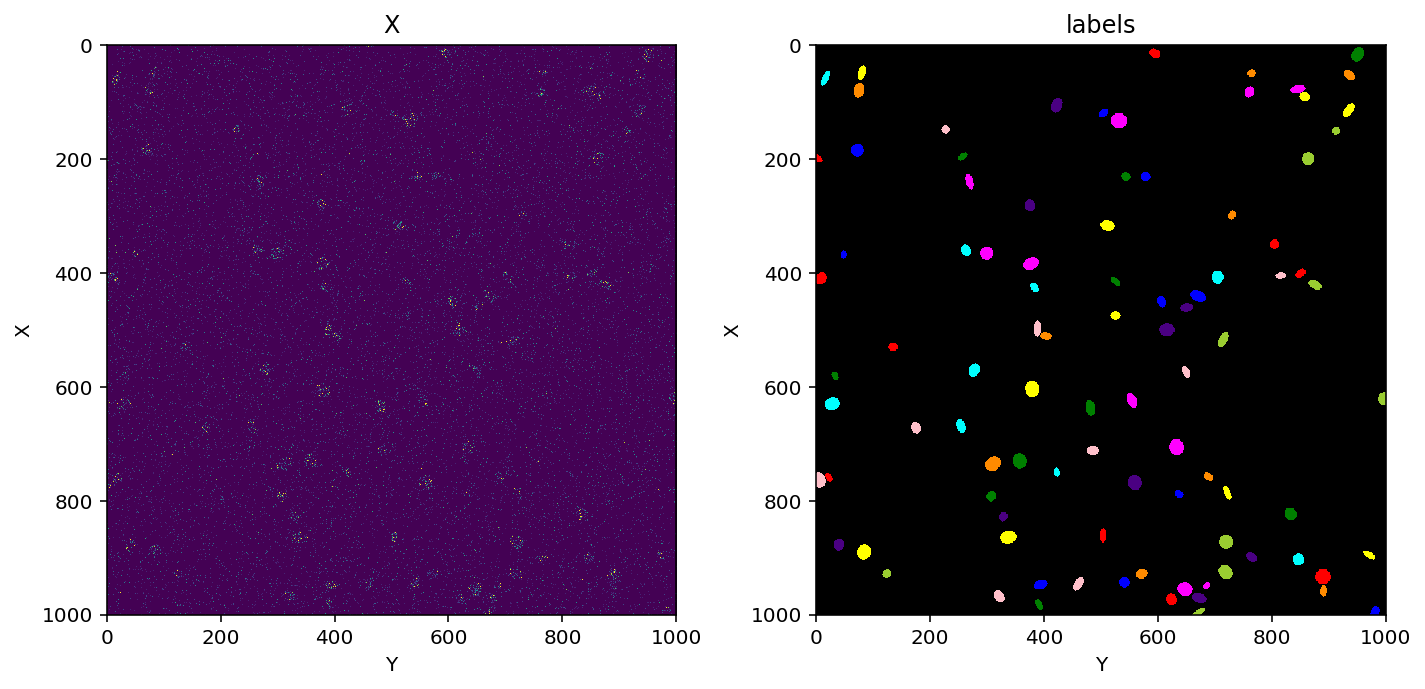

In [3]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5), tight_layout=True)
st.pl.imshow(adata, vmax=10, ax=axes[0], save_show_or_return='return')
st.pl.imshow(adata, 'labels', labels=True, ax=axes[1])

## Showcase a few different algorithms

In [4]:
# Simple Gaussian blur + thresholding
st.pp.segmentation.score_and_mask_pixels(
    adata, 'X', k=21, method='gauss',
    scores_layer='gauss_scores', mask_layer='gauss_mask'
)

# Negative Binomial mixture expectation maximization (EM)
# Arguments to EM algorithm can be changed with em_kwargs
st.pp.segmentation.score_and_mask_pixels(
    adata, 'X', k=7, method='EM',
    em_kwargs=dict(downsample=0.1, max_iter=2000, precision=1e-6, seed=0),
    scores_layer='EM_scores', mask_layer='EM_mask'
)

# Negative Binomial mixture expectation maximization (EM) + belief propagation (BP)
# Arguments to EM and BP algorithms can be changed with em_kwargs and bp_kwargs
st.pp.segmentation.score_and_mask_pixels(
    adata, 'X', k=7, method='EM+BP',
    em_kwargs=dict(downsample=0.01, max_iter=2000, precision=1e-6, seed=0),
    bp_kwargs=dict(k=3, square=False, p=0.6, q=0.4, precision=1e-6, max_iter=100),
    scores_layer='EM+BP_scores', mask_layer='EM+BP_mask'
)

# Negative Binomial mixture variational inference (VI) + belief propagation (BP)
# Arguments to VI and BP algorithms can be changed with vi_kwargs and bp_kwargs
st.pp.segmentation.score_and_mask_pixels(
    adata, 'X', k=7, method='VI+BP',
    vi_kwargs=dict(downsample=0.1, n_epochs=500, zero_inflated=False, seed=0),
    bp_kwargs=dict(k=3, square=False, p=0.6, q=0.4, precision=1e-6, max_iter=100),
    scores_layer='VI+BP_scores', mask_layer='VI+BP_mask'
)

# Moran's I
st.pp.segmentation.score_and_mask_pixels(
    adata, 'X', k=21, method='moran',
    moran_kwargs=dict(k=7, p_threshold=0.05),
    scores_layer='moran_scores', mask_layer='moran_mask'
)

|-----> <select> X layer in AnnData Object
|-----> Scoring pixels with gauss method.
|-----> <insert> gauss_scores to layers in AnnData Object.
|-----> Applying threshold 0.248046875.
|-----> <insert> gauss_mask to layers in AnnData Object.
|-----> <select> X layer in AnnData Object
|-----> Scoring pixels with em method.


Running EM: 100%|#################################################################################################################| 1/1 [00:29<00:00, 29.98s/it]


|-----> <insert> EM_scores to layers in AnnData Object.
|-----> Applying threshold 0.40040198590098036.
|-----> <insert> EM_mask to layers in AnnData Object.
|-----> <select> X layer in AnnData Object
|-----> Scoring pixels with em+bp method.


Running EM: 100%|#################################################################################################################| 1/1 [00:12<00:00, 12.88s/it]


|-----> <insert> EM+BP_scores to layers in AnnData Object.
|-----> Applying threshold 0.6660291463449997.
|-----> <insert> EM+BP_mask to layers in AnnData Object.
|-----> <select> X layer in AnnData Object
|-----> Scoring pixels with vi+bp method.


Loss 2.2614e+00: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:08<00:00, 61.84it/s]


|-----> <insert> VI+BP_scores to layers in AnnData Object.
|-----> Applying threshold 0.666012896434159.
|-----> <insert> VI+BP_mask to layers in AnnData Object.
|-----> <select> X layer in AnnData Object
|-----> Scoring pixels with moran method.
|-----> <insert> moran_scores to layers in AnnData Object.
|-----> Applying threshold 0.21116271276786516.
|-----> <insert> moran_mask to layers in AnnData Object.


|-----> <select> gauss_scores layer in AnnData Object
|-----> <select> gauss_mask layer in AnnData Object
|-----> <select> EM_scores layer in AnnData Object
|-----> <select> EM_mask layer in AnnData Object
|-----> <select> EM+BP_scores layer in AnnData Object
|-----> <select> EM+BP_mask layer in AnnData Object
|-----> <select> VI+BP_scores layer in AnnData Object
|-----> <select> VI+BP_mask layer in AnnData Object
|-----> <select> moran_scores layer in AnnData Object
|-----> <select> moran_mask layer in AnnData Object


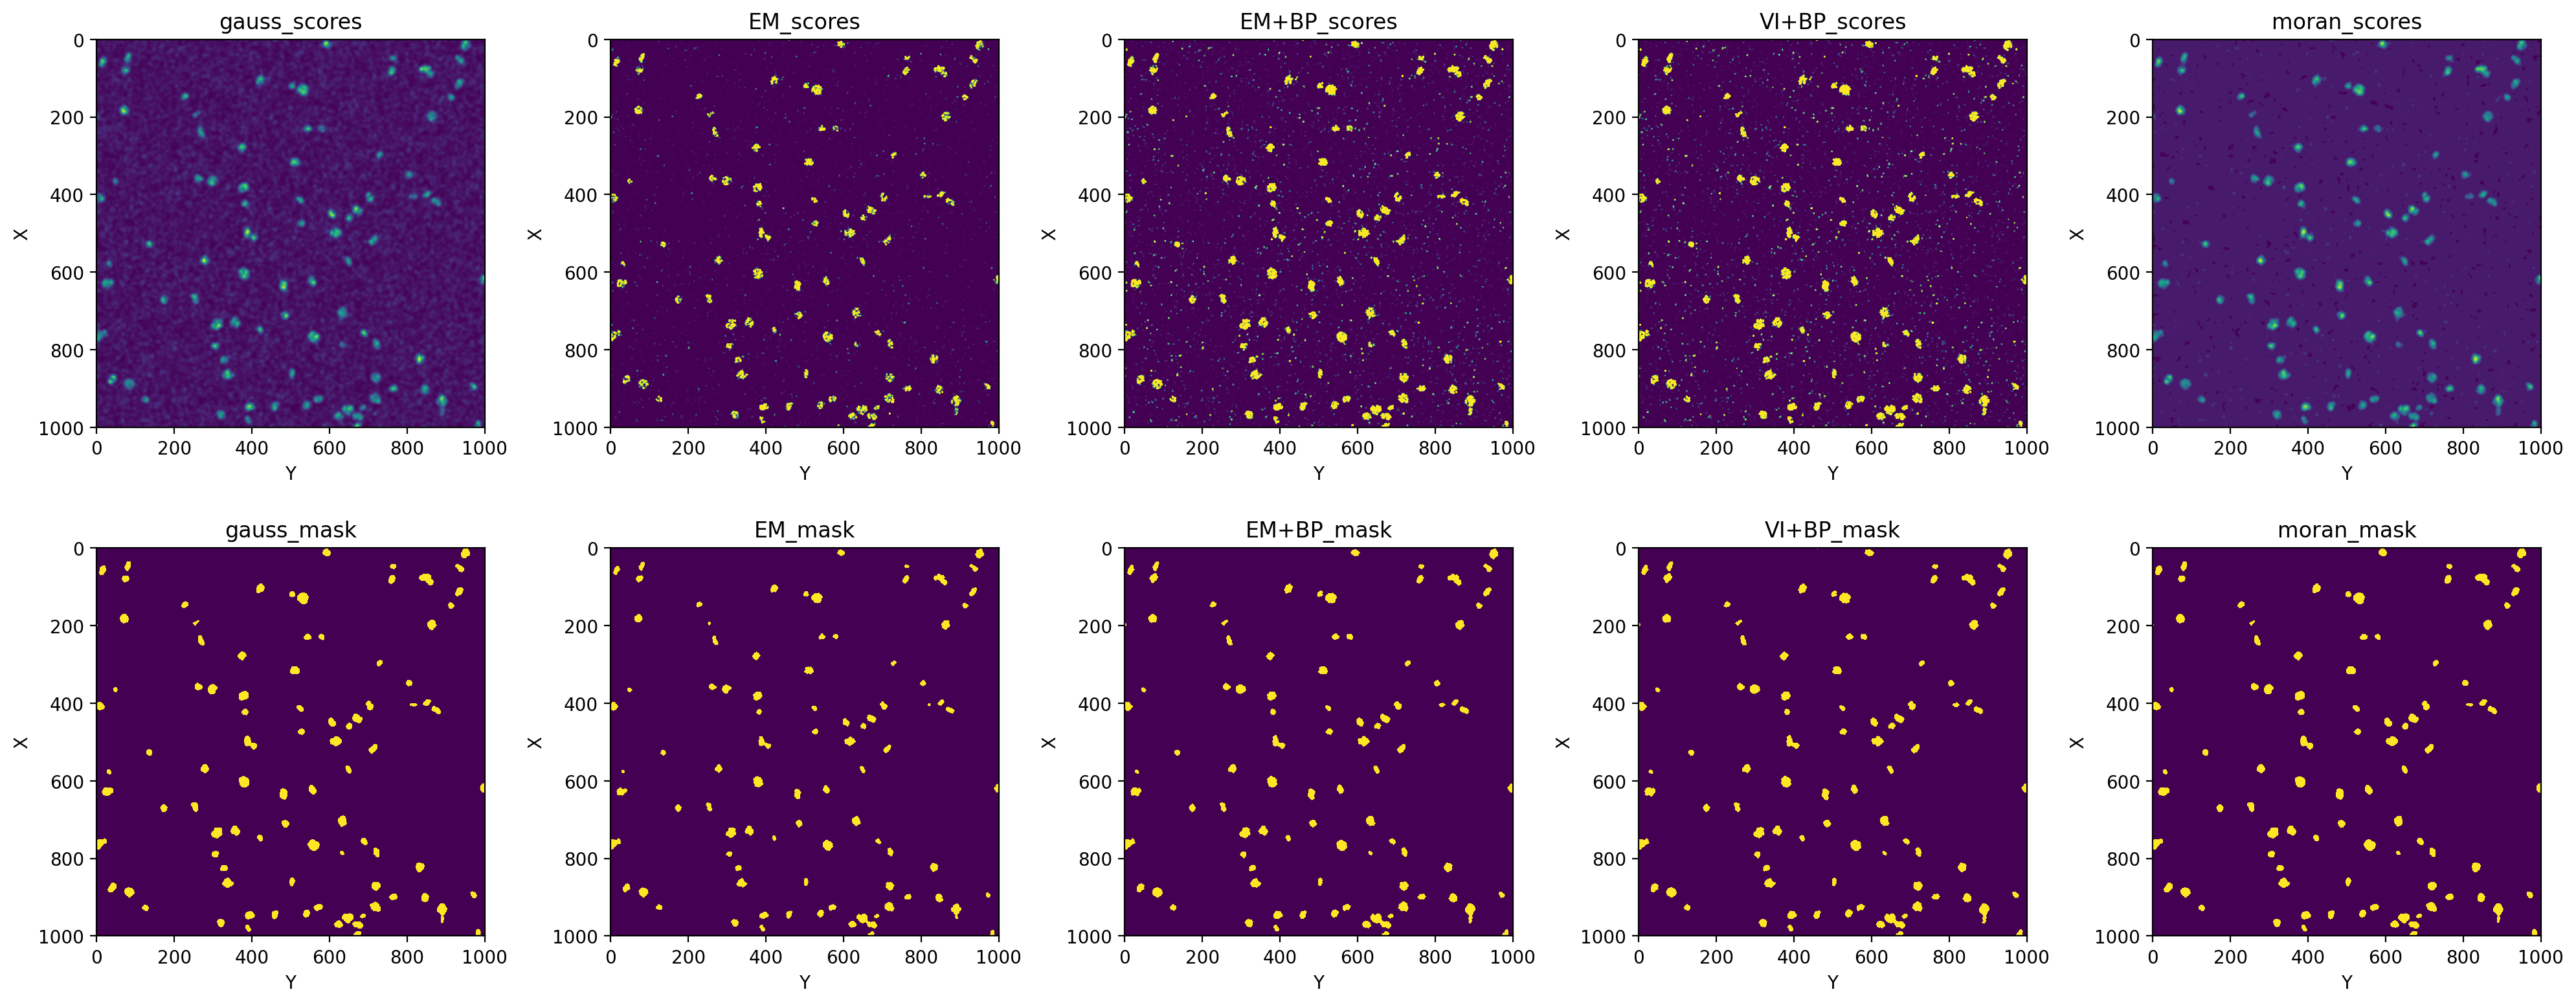

In [5]:
methods = ['gauss', 'EM', 'EM+BP', 'VI+BP', 'moran']
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(4*5, 4*2), tight_layout=True)
for i, method in enumerate(methods):
    st.pl.imshow(adata, f'{method}_scores', ax=axes[:,i][0], save_show_or_return='return')
    st.pl.imshow(adata, f'{method}_mask', ax=axes[:,i][1], save_show_or_return='return')

## Calculate performance

Naively label each connected component. In other words, each connected set of pixels are labeled as a single label.

In [6]:
# Naively label each connected component as a unique lable.
compare_dfs = []
for method in methods:
    st.pp.segmentation.label_connected_components(adata, method, area_threshold=np.inf)
    compare_dfs.append(st.pp.segmentation.compare(adata, 'labels', f'{method}_labels', random_background=False))
performance_df = pd.concat(compare_dfs, axis=1)
performance_df

|-----> <select> gauss_mask layer in AnnData Object
|-----> <insert> gauss_labels to layers in AnnData Object.
|-----> <select> labels layer in AnnData Object
|-----> <select> gauss_labels layer in AnnData Object
|-----> <select> X layer in AnnData Object
|-----> Computing statistics.
|-----> <select> EM_mask layer in AnnData Object
|-----> <insert> EM_labels to layers in AnnData Object.
|-----> <select> labels layer in AnnData Object
|-----> <select> EM_labels layer in AnnData Object
|-----> <select> X layer in AnnData Object
|-----> Computing statistics.
|-----> <select> EM+BP_mask layer in AnnData Object
|-----> <insert> EM+BP_labels to layers in AnnData Object.
|-----> <select> labels layer in AnnData Object
|-----> <select> EM+BP_labels layer in AnnData Object
|-----> <select> X layer in AnnData Object
|-----> Computing statistics.
|-----> <select> VI+BP_mask layer in AnnData Object
|-----> <insert> VI+BP_labels to layers in AnnData Object.
|-----> <select> labels layer in AnnData

,gauss_labels,EM_labels,EM+BP_labels,VI+BP_labels,moran_labels
True negative,0.993609,0.997489,0.995161,0.994704,0.993677
False positive,0.006391,0.002511,0.004839,0.005296,0.006323
False negative,0.057917,0.141285,0.063007,0.055441,0.065484
True positive,0.942083,0.858715,0.936993,0.944559,0.934516
Precision,0.960718,0.982683,0.969813,0.967315,0.960820
Accuracy,0.986276,0.977740,0.986883,0.987568,0.985258
F1 score,0.951309,0.916526,0.953121,0.955801,0.947486
Adjusted rand score,0.970260,0.952253,0.949628,0.949924,0.970636
Homogeneity,0.988716,0.984059,0.983492,0.983543,0.988777
Completeness,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
ap_df = performance_df.filter(regex='Average precision', axis=0)
ap_df['tau'] = ap_df.index.str.split(' ').str[-1].str.strip('()').astype(float)
ap_df.reset_index(drop=True, inplace=True)
ap_df

,gauss_labels,EM_labels,EM+BP_labels,VI+BP_labels,moran_labels,tau
0,0.900990,0.843137,0.900000,0.891089,0.910000,0.50
1,0.900990,0.807692,0.900000,0.891089,0.910000,0.55
2,0.846154,0.790476,0.862745,0.854369,0.854369,0.60
3,0.846154,0.724771,0.826923,0.819048,0.819048,0.65
4,0.828571,0.693694,0.792453,0.801887,0.801887,0.70
5,0.761468,0.663717,0.743119,0.768519,0.768519,0.75
6,0.699115,0.553719,0.696429,0.705357,0.720721,0.80
7,0.669565,0.342857,0.681416,0.675439,0.618644,0.85
8,0.361702,0.119048,0.386861,0.425373,0.317241,0.90
9,0.090909,0.016216,0.073446,0.091429,0.085227,0.95


<AxesSubplot:xlabel='tau', ylabel='average precision'>

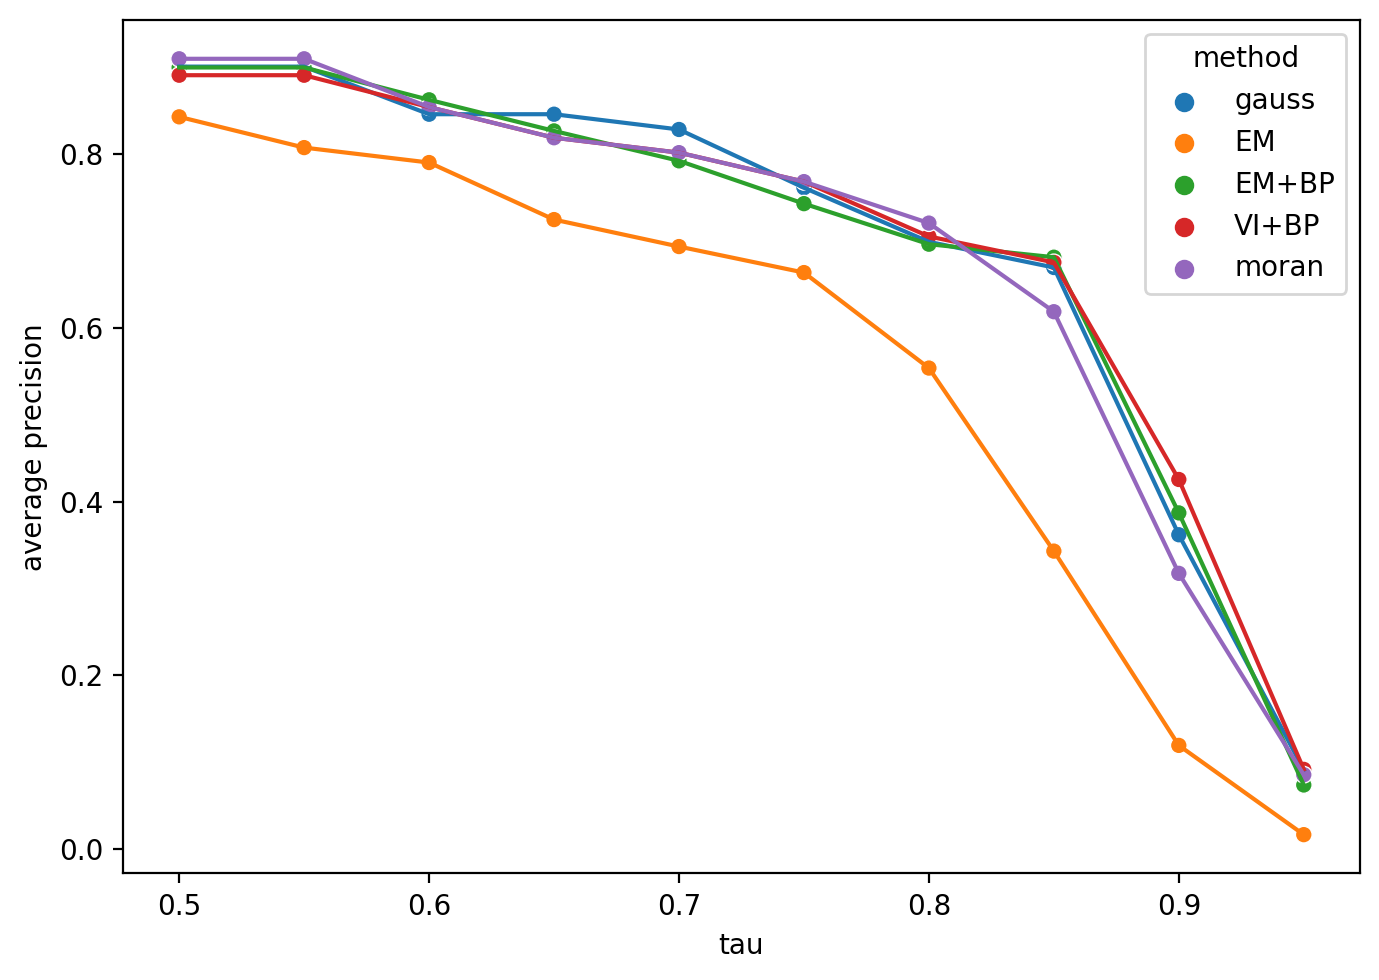

In [8]:
fig, ax = plt.subplots(figsize=(7, 5), tight_layout=True)
data = pd.melt(ap_df, id_vars='tau', value_name='average precision', var_name='method')
data['method'] = data['method'].str.split('_').str[0]
sns.scatterplot(data=data, x='tau', y='average precision', hue='method', ax=ax)
sns.lineplot(data=data, x='tau', y='average precision', hue='method', ax=ax, legend=False)

Label connected components, while splitting large components. This can help split cells that seem connected. This can also help identify cells in dense regions (not simulated in this notebook).

In [9]:
# Attempt to split connected components that are larger than 500 pixels.
compare_dfs = []
for method in methods:
    st.pp.segmentation.label_connected_components(adata, method, area_threshold=500)
    compare_dfs.append(st.pp.segmentation.compare(adata, 'labels', f'{method}_labels', random_background=False))
performance_df = pd.concat(compare_dfs, axis=1)
performance_df

|-----> <select> gauss_mask layer in AnnData Object


Eroding: 11it [00:00, 722.49it/s]
Expanding:   0%|                                                                                                                          | 0/8 [00:00<?, ?it/s]OMP: Info #270: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #270: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
Expanding: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:15<00:00,  1.98s/it]

|-----> <insert> gauss_labels to layers in AnnData Object.
|-----> <select> labels layer in AnnData Object
|-----> <select> gauss_labels layer in AnnData Object
|-----> <select> X layer in AnnData Object
|-----> Computing statistics.


|-----> <select> EM_mask layer in AnnData Object


Eroding: 10it [00:00, 756.38it/s]
Expanding: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.15it/s]

|-----> <insert> EM_labels to layers in AnnData Object.
|-----> <select> labels layer in AnnData Object
|-----> <select> EM_labels layer in AnnData Object
|-----> <select> X layer in AnnData Object
|-----> Computing statistics.


|-----> <select> EM+BP_mask layer in AnnData Object


Eroding: 11it [00:00, 664.82it/s]
Expanding: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.77it/s]

|-----> <insert> EM+BP_labels to layers in AnnData Object.
|-----> <select> labels layer in AnnData Object
|-----> <select> EM+BP_labels layer in AnnData Object
|-----> <select> X layer in AnnData Object
|-----> Computing statistics.


|-----> <select> VI+BP_mask layer in AnnData Object


Eroding: 11it [00:00, 671.68it/s]
Expanding: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.60it/s]

|-----> <insert> VI+BP_labels to layers in AnnData Object.
|-----> <select> labels layer in AnnData Object
|-----> <select> VI+BP_labels layer in AnnData Object
|-----> <select> X layer in AnnData Object
|-----> Computing statistics.


|-----> <select> moran_mask layer in AnnData Object


Eroding: 11it [00:00, 787.23it/s]
Expanding: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.71it/s]

|-----> <insert> moran_labels to layers in AnnData Object.
|-----> <select> labels layer in AnnData Object
|-----> <select> moran_labels layer in AnnData Object
|-----> <select> X layer in AnnData Object
|-----> Computing statistics.


,gauss_labels,EM_labels,EM+BP_labels,VI+BP_labels,moran_labels
True negative,0.994910,0.997900,0.995983,0.995595,0.994819
False positive,0.005090,0.002100,0.004017,0.004405,0.005181
False negative,0.101940,0.163434,0.102352,0.095336,0.106067
True positive,0.898060,0.836566,0.897648,0.904664,0.893933
Precision,0.966968,0.985096,0.973735,0.971488,0.966245
Accuracy,0.981127,0.974941,0.981989,0.982654,0.980462
F1 score,0.931241,0.904776,0.934145,0.936886,0.928684
Adjusted rand score,0.992941,0.987035,0.987993,0.990197,0.993001
Homogeneity,0.996777,0.994377,0.996293,0.996635,0.996780
Completeness,0.999594,0.999565,0.996772,0.997589,0.999592


In [10]:
ap_df = performance_df.filter(regex='Average precision', axis=0)
ap_df['tau'] = ap_df.index.str.split(' ').str[-1].str.strip('()').astype(float)
ap_df.reset_index(drop=True, inplace=True)
ap_df

,gauss_labels,EM_labels,EM+BP_labels,VI+BP_labels,moran_labels,tau
0,0.920792,0.854369,0.893204,0.893204,0.930000,0.50
1,0.901961,0.819048,0.893204,0.893204,0.910891,0.55
2,0.883495,0.819048,0.875000,0.893204,0.892157,0.60
3,0.883495,0.768519,0.839623,0.857143,0.855769,0.65
4,0.847619,0.736364,0.805556,0.839623,0.820755,0.70
5,0.796296,0.675439,0.741071,0.805556,0.770642,0.75
6,0.658120,0.540323,0.652542,0.710526,0.692982,0.80
7,0.616667,0.317241,0.598361,0.625000,0.595041,0.85
8,0.293333,0.097701,0.308725,0.344828,0.245161,0.90
9,0.083799,0.015957,0.059783,0.071429,0.078212,0.95


<AxesSubplot:xlabel='tau', ylabel='average precision'>

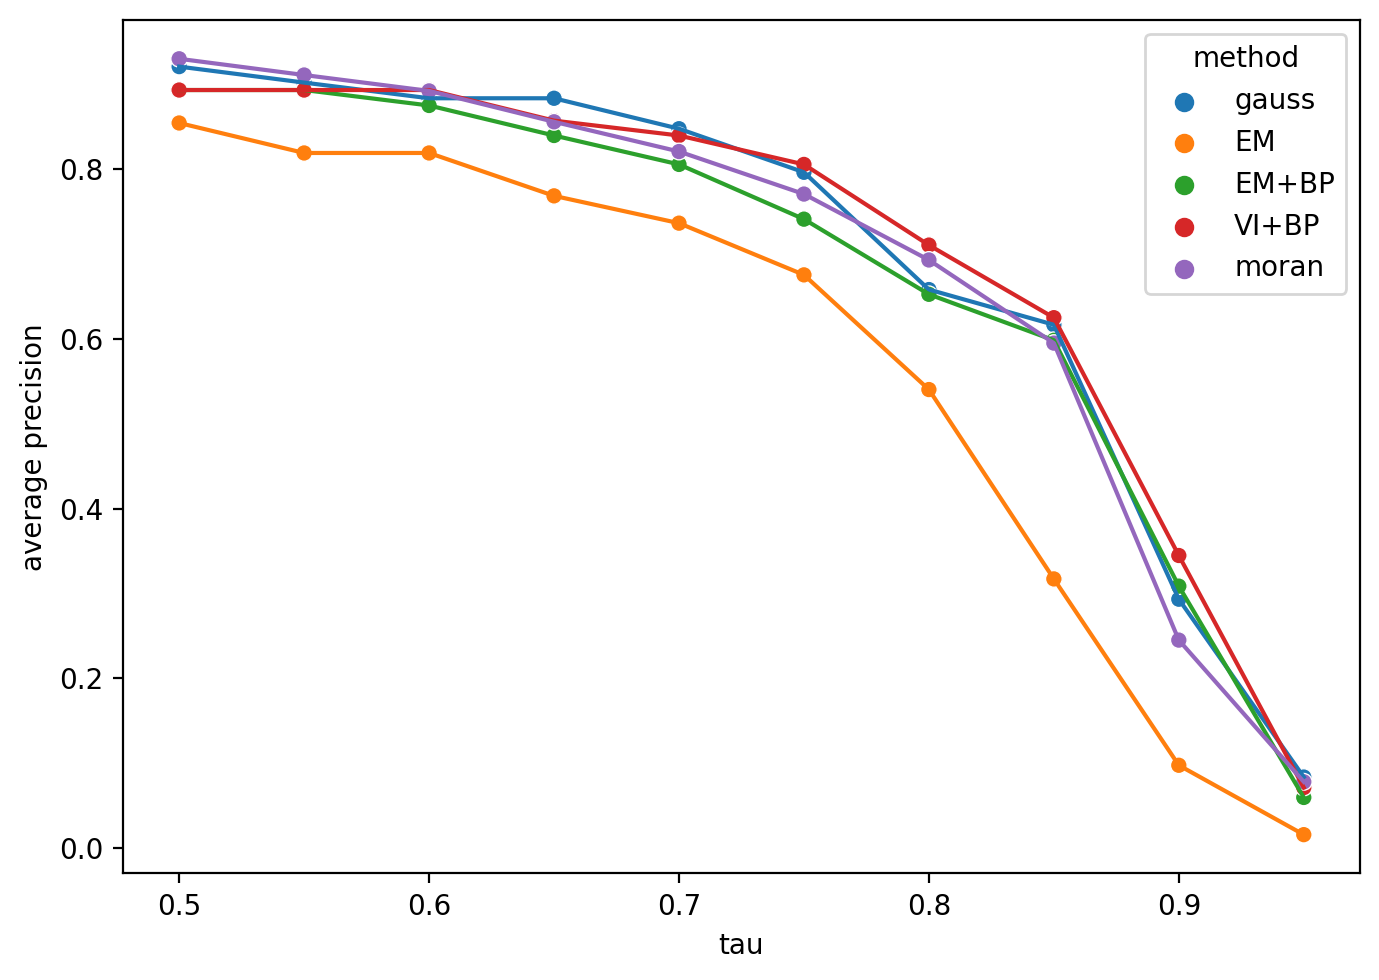

In [11]:
fig, ax = plt.subplots(figsize=(7, 5), tight_layout=True)
data = pd.melt(ap_df, id_vars='tau', value_name='average precision', var_name='method')
data['method'] = data['method'].str.split('_').str[0]
sns.scatterplot(data=data, x='tau', y='average precision', hue='method', ax=ax)
sns.lineplot(data=data, x='tau', y='average precision', hue='method', ax=ax, legend=False)